<h1> Brain Tumor Detection using Pre-Trained ResNet50 model </h1>

<p> In this notebook, detection of Brain tumors has been done by using Computer Vision. A pre-trained ResNet50 model with ImageNet weights has been used to perform this task. Keras API and tensorflow have been used in this notebook </p>

<h2> Importing necessary Libraries </h2> 

In [29]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [30]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

print("All modules have been imported")

All modules have been imported


<h2> Creating a required directory structure </h2>

In [31]:
# change base to a full path if you want (e.g., r"C:\medvision")
base = "C:\medvision\data"

dirs = [
    os.path.join(base, "TRAIN", "YES"),
    os.path.join(base, "TRAIN", "NO"),
    os.path.join(base, "TEST", "YES"),
    os.path.join(base, "TEST", "NO"),
    os.path.join(base, "VAL", "YES"),
    os.path.join(base, "VAL", "NO"),
]

for d in dirs:
    os.makedirs(d, exist_ok=True)

clear_output()
# Show folders only (Windows tree)
!tree "{base}" /A


Folder PATH listing for volume Windows-SSD
Volume serial number is 1A6B-E0F6
C:\MEDVISION\DATA
+---TEST
|   +---NO
|   \---YES
+---TRAIN
|   +---NO
|   \---YES
\---VAL
    +---NO
    \---YES


In [32]:
from pathlib import Path

SRC = Path(r"C:\medvision\Brain_Tumor_Detection")   # where class folders are
DST = Path(r"C:\medvision\data")                     # where TRAIN/TEST/VAL live
ignored = {"pred"}

# Make sure target folders exist for each class
for CLASS in os.listdir(SRC):
    if CLASS in ignored or CLASS.startswith('.'):
        continue
    for split in ["TRAIN", "TEST", "VAL"]:
        (DST / split / CLASS.upper()).mkdir(parents=True, exist_ok=True)

# Copy with deterministic ordering
for CLASS in os.listdir(SRC):
    if CLASS in ignored or CLASS.startswith('.'):
        continue

    class_dir = SRC / CLASS
    files = sorted([f for f in os.listdir(class_dir) if not f.startswith('.')])
    IMG_NUM = len(files)

    for n, FILE_NAME in enumerate(files):
        src = class_dir / FILE_NAME
        if n < 300:
            dst = DST / "TEST" / CLASS.upper() / FILE_NAME
        elif n < int(0.8 * IMG_NUM):
            dst = DST / "TRAIN" / CLASS.upper() / FILE_NAME
        else:
            dst = DST / "VAL" / CLASS.upper() / FILE_NAME

        shutil.copy2(src, dst)


In [36]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    if img is not None:  # Check if image was loaded successfully
                        img = cv2.resize(img, dsize=img_size, interpolation=cv2.INTER_CUBIC)
                        X.append(img)
                        y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [34]:
TRAIN_DIR = 'C:/medvision/data/TRAIN/'
TEST_DIR = 'C:/medvision/data/TEST/'
VAL_DIR = 'C:/medvision/data/VAL/'
IMG_SIZE = (224,224)

In [37]:
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


1800 images loaded from C:/medvision/data/TRAIN/ directory.


100%|██████████| 2/2 [00:07<00:00,  3.96s/it]


600 images loaded from C:/medvision/data/TEST/ directory.


100%|██████████| 2/2 [00:08<00:00,  4.15s/it]

600 images loaded from C:/medvision/data/VAL/ directory.


<h2> Plotting the number of samples in Training, Validation and Test sets </h2>

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\Yatharth Vashisht\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


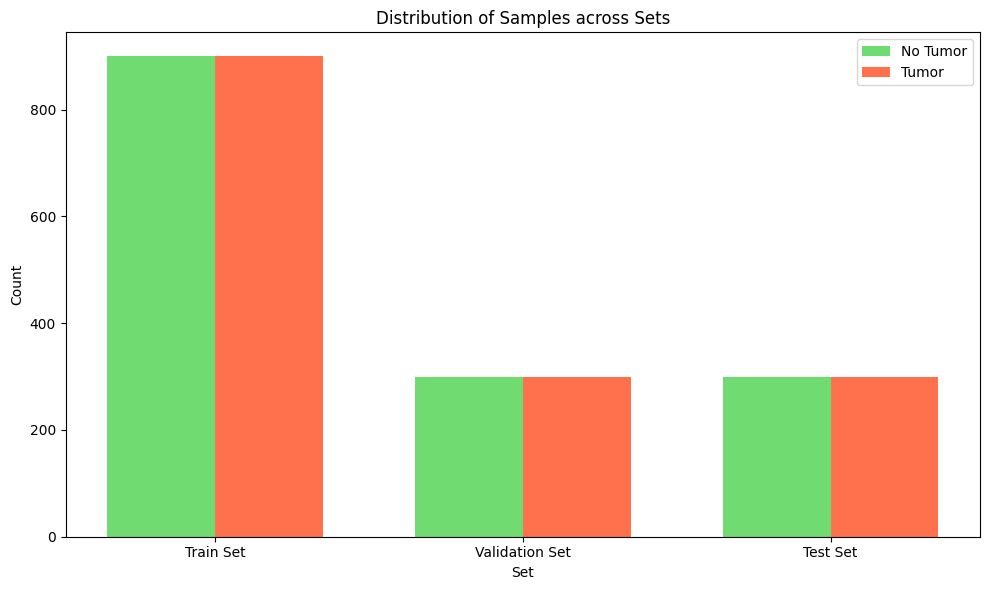

In [40]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
%pip install nbformat>=4.2.0

# Count samples in each set
y = dict()
y[0] = []  # No tumor
y[1] = []  # Yes tumor
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

# Create bar plot
plt.figure(figsize=(10,6))
x = ['Train Set', 'Validation Set', 'Test Set']
width = 0.35
plt.bar(np.arange(len(x)), y[0], width, label='No Tumor', color='#33cc33', alpha=0.7)
plt.bar(np.arange(len(x)) + width, y[1], width, label='Tumor', color='#ff3300', alpha=0.7)

plt.xlabel('Set')
plt.ylabel('Count')
plt.title('Distribution of Samples across Sets')
plt.xticks(np.arange(len(x)) + width/2, x)
plt.legend()
plt.tight_layout()
plt.show()


<h2> Let's Visualize the images we are working with </h2>

In [41]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

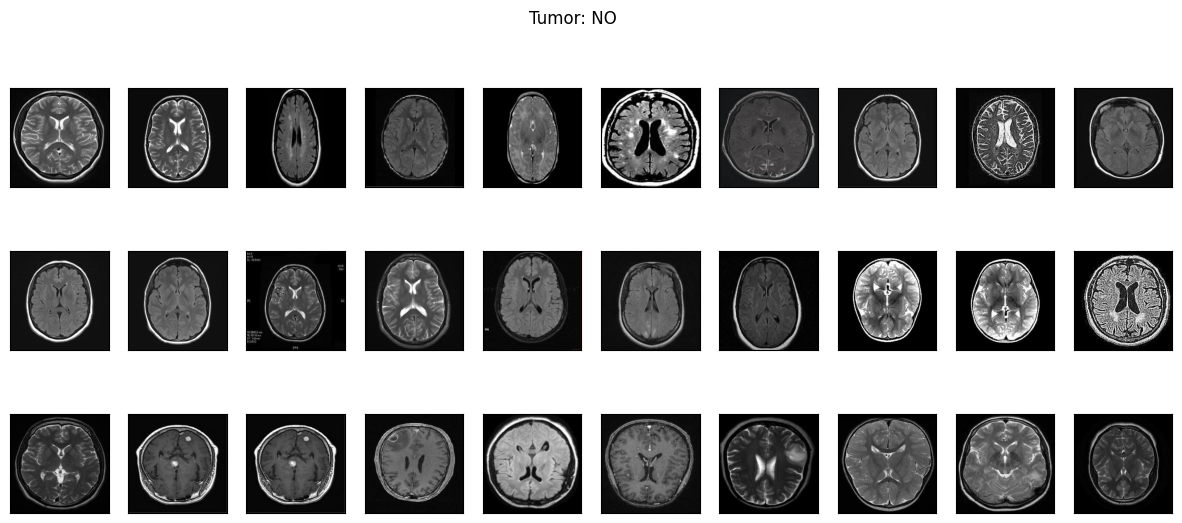

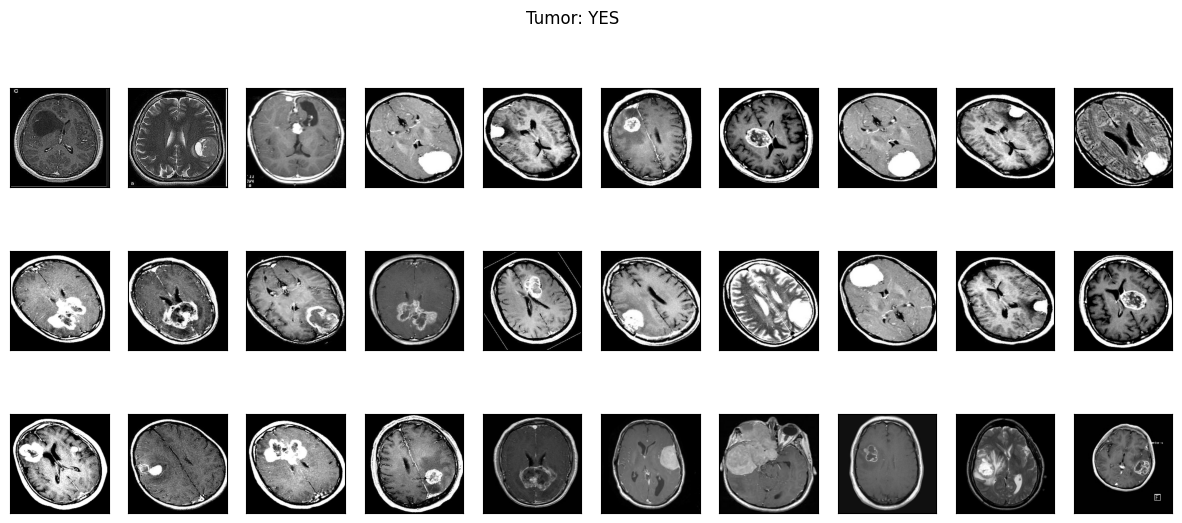

In [42]:
plot_samples(X_train, y_train, labels, 30)

<h2> Cropping the images </h2>

<p> The images we have are of different sizes. But our model accepts images of size (224*224*3) as input. To achienve this ew have to resize the images. Blindly resizing the images can lead to extreme distortions in the images. Hence, We will first crop thie images and then resize them. This will minimize the issue of distortions. </p>

<p> This cropping is done by finding contours in the images using the OpenCV Library </p>

In [56]:
def crop_imgs(images, target_size=(224, 224), add_pixels=8):
    """
    Crop around the largest foreground region and resize to a fixed size.
    images: list/array of (H,W,3) RGB images
    returns: np.ndarray of shape (N, target_size[1], target_size[0], 3)
    """
    out = []
    tw, th = target_size

    for img in images:
        # ensure 3-channel RGB
        if img.ndim == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)

        h, w = img.shape[:2]

        # robust mask
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        thresh = cv2.erode(thresh, None, iterations=1)
        thresh = cv2.dilate(thresh, None, iterations=1)

        cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not cnts:
            # fallback to full image
            x0, y0, x1, y1 = 0, 0, w, h
        else:
            c = max(cnts, key=cv2.contourArea)
            x, y, cw, ch = cv2.boundingRect(c)
            # expand & clamp
            x0 = max(0, x - add_pixels)
            y0 = max(0, y - add_pixels)
            x1 = min(w, x + cw + add_pixels)
            y1 = min(h, y + ch + add_pixels)
            if x1 <= x0 or y1 <= y0:
                x0, y0, x1, y1 = 0, 0, w, h

        crop = img[y0:y1, x0:x1]
        # final uniform size so stacking works
        crop = cv2.resize(crop, (tw, th), interpolation=cv2.INTER_AREA)
        out.append(crop)

    return np.stack(out, axis=0)  # (N, th, tw, 3)

In [47]:
import imutils
img_path = os.path.join(VAL_DIR, 'NO', 'no852.jpg')
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Could not load image file: {img_path}")
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

<h2> Let's visualize how the cropping works </h2>

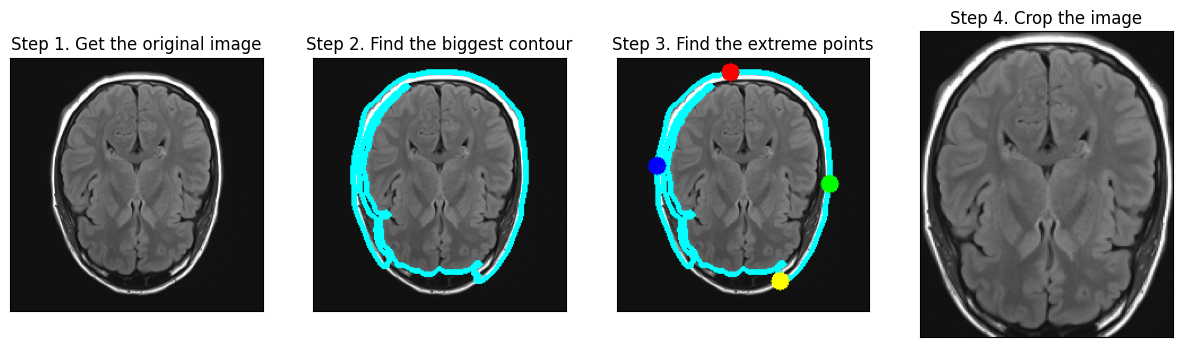

In [48]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [58]:
X_train_crop = crop_imgs(X_train)
X_val_crop   = crop_imgs(X_val)
X_test_crop  = crop_imgs(X_test)


<h2> Let's visualize the images after being cropped </h2>

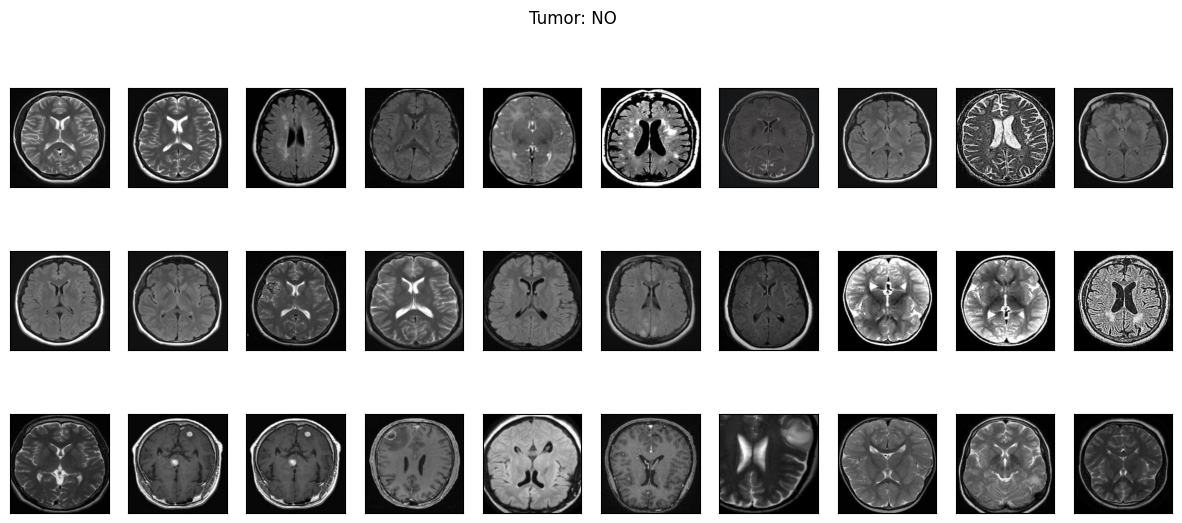

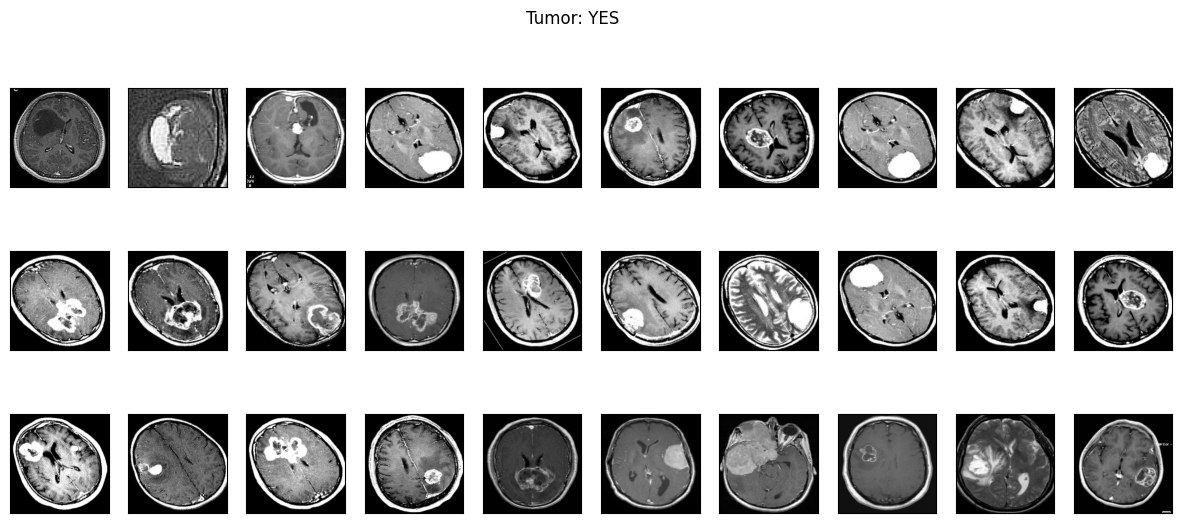

In [59]:
plot_samples(X_train_crop, y_train, labels, 30)

In [60]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [ ]:
# saving new images to the folder
DATA_DIR = r"C:\medvision\data"

for p in [
    "TRAIN_CROP/YES", "TRAIN_CROP/NO",
    "TEST_CROP/YES",  "TEST_CROP/NO",
    "VAL_CROP/YES",   "VAL_CROP/NO"
]:
    os.makedirs(os.path.join(DATA_DIR, p), exist_ok=True)

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

The syntax of the command is incorrect.


<h2> Resizing the images </h2>

<p> Now that we have cropped the images, we can resize them without suffering from heavy distortions or resizing artefacts </p>

In [ ]:
def preprocess_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)


In [ ]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

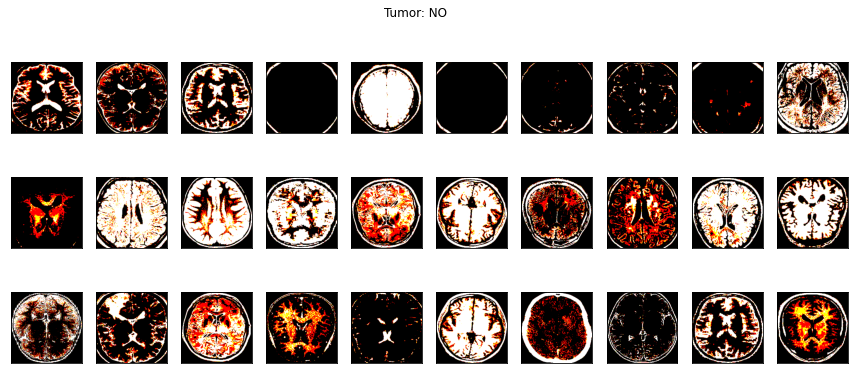

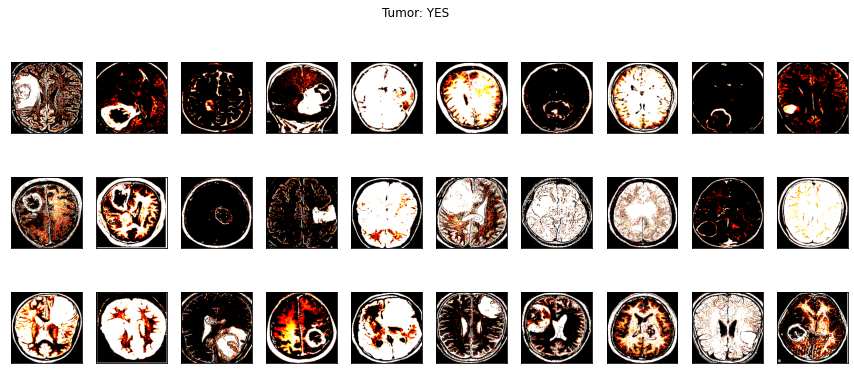

In [ ]:
plot_samples(X_train_prep, y_train, labels, 30)

<h2> Image Augmentation </h2>
<p> We will perform data augmentation to increase the number of training samples we have </p>

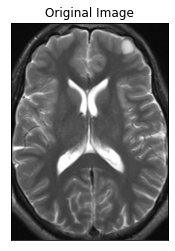

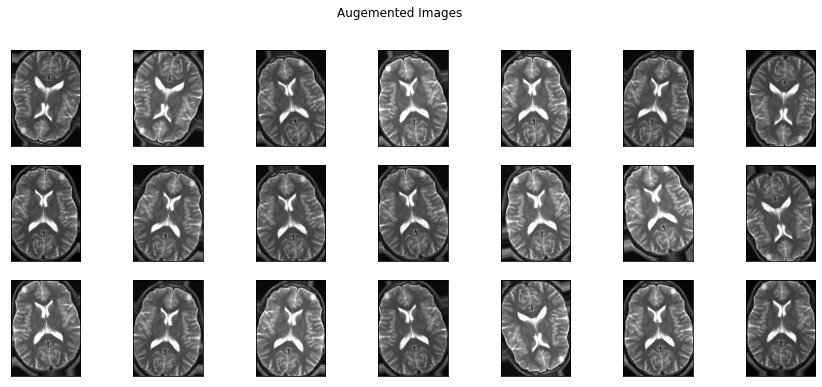

In [ ]:
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 
        
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()


In [ ]:
!rm -rf preview/

In [ ]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'
RANDOM_SEED = 42
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


<h2> Creating the model </h2>

<p> Here we will be using a pretrained ResNet50 model with ImageNet weights from keras. We will use transfer learning for this task. We will be using binary cross entropy as the loss function and accuracy and AUC as our monitoring metrics. </p>

In [ ]:
base_Neural_Net= ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

for layer in base_Neural_Net.layers:
    layer.trainable = False

    
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy' , 'AUC']
)

model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________

<h2> TRAINING !!! </h2>

In [ ]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)
history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
50/50 [==============================] - 33s 536ms/step - loss: 0.5047 - accuracy: 0.7962 - auc: 0.8733 - val_loss: 0.1728 - val_accuracy: 0.9500 - val_auc: 0.9814
Epoch 2/30
50/50 [==============================] - 24s 494ms/step - loss: 0.2241 - accuracy: 0.9123 - auc: 0.9699 - val_loss: 0.1437 - val_accuracy: 0.9500 - val_auc: 0.9869
Epoch 3/30
50/50 [==============================] - 24s 479ms/step - loss: 0.1524 - accuracy: 0.9408 - auc: 0.9867 - val_loss: 0.1102 - val_accuracy: 0.9425 - val_auc: 0.9930
Epoch 4/30
50/50 [==============================] - 25s 491ms/step - loss: 0.1460 - accuracy: 0.9469 - auc: 0.9868 - val_loss: 0.0851 - val_accuracy: 0.9600 - val_auc: 0.9958
Epoch 5/30
50/50 [==============================] - 25s 502ms/step - loss: 0.1189 - accuracy: 0.9590 - auc: 0.9905 - val_loss: 0.0657 - val_accuracy: 0.9750 - val_auc: 0.9983
Epoch 6/30
50/50 [==============================] - 25s 491ms/step - loss: 0.1159 - accuracy: 0.9571 - auc: 0.9917 - val_loss

<h2>Let's have a look at the performance of our model </h2>

<h3> Validating with the training set </h3>

Train Accuracy = 1.00


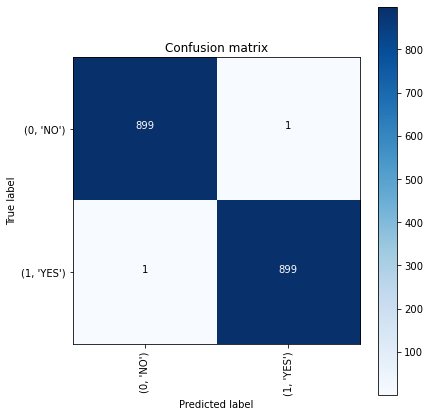

In [ ]:
predictions = model.predict(X_train_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_train, predictions)
print('Train Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_train, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

<h3> Validating with the Validation set</h3>

Val Accuracy = 0.99


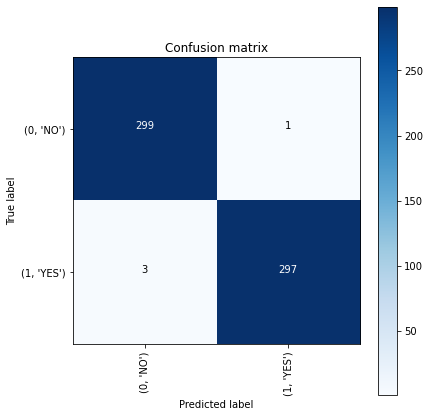

In [ ]:
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

* <h3> Validating with the Test set</h3>

Test Accuracy = 0.99


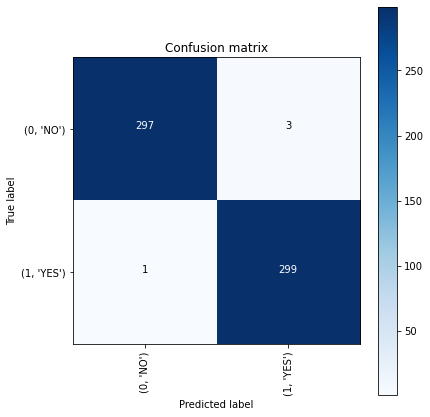

In [ ]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
prob_pred = model.predict_proba(X_test_prep)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning:

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.



<h2> Let's see the other performance metrics on the test set </h2>

In [ ]:
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test, predictions),4))
print('Precision score is :', np.round(metrics.precision_score(y_test, predictions, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test, predictions, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test, predictions, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test, prob_pred,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, predictions),4))

print('\t\tClassification Report:\n', metrics.classification_report(y_test, predictions))

Accuracy score is : 0.9933
Precision score is : 0.9934
Recall score is : 0.9933
F1 Score is : 0.9933
ROC AUC Score is : 0.9986
Cohen Kappa Score: 0.9867
		Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       300
           1       0.99      1.00      0.99       300

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



In [ ]:
# --- Save full Keras model for inference ---
# (Run this after model.fit(...))
from tensorflow.keras.models import save_model
# This saves architecture + weights + optimizer state in one file.
model.save("resnet50_brain.h5")
print("Saved: resnet50_brain.h5")


<h2> Conclusion </h2>
<p> A seen from the metrics, the model performs pretty well. We are able to correctly classify all the images in the test set with very few false positives and false negatives in the validation set. This performance can be firther enhanced by hyper parameter tuning. </p>

In [ ]:
# clean up the space
!rm -rf TRAIN TEST VAL TRAIN_CROP TEST_CROP VAL_CROP